In [1]:
# Make imports 

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Set random seeds for reproducible results

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Define the XNOR dataset

class XNORDataset(Dataset):
    def __init__(self, size):
        self.X = 2*np.random.uniform(size=(size, 2)).astype(np.float32) - 1
        self.y = ((np.sign(np.prod(self.X, axis=1))+1)/2).astype(int)
        
    def __getitem__(self, idx):
        
        try: idx = idx.item()
        except: pass
        
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return self.y.shape[0]

In [4]:
dataset = XNORDataset(10000)

# split in 70:15:15 ratio
test_size = int(0.15*len(dataset))
train_size, val_size = len(dataset) - 2*test_size, test_size
trainset, valset, testset = random_split(dataset, lengths=[train_size, val_size, test_size])

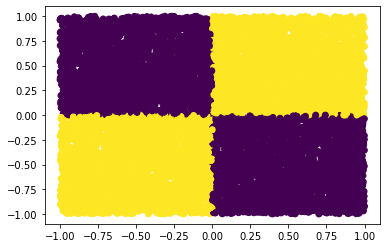

In [5]:
# visualize the dataset
plt.scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.y)

In [6]:
batch_size = 16

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size)

In [7]:
# Define classification model

class XNOR_NN(nn.Module):
    def __init__(self, hiddensize=4):
        super().__init__()
        self.fc1 = nn.Linear(2, hiddensize)
        self.fc2 = nn.Linear(hiddensize, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, axis=-1)

In [8]:
# helper functions for training and evaluation

def train_epoch(model, iterator, optimizer, criterion):
    model.train() # Set to train mode
    
    epoch_loss = 0
    correct, total = 0, 0
    for X, y in iterator:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() # zero out previously accumulated gradients
        
        output = model(X)
        
        loss = criterion(output, y) # calculate loss using criterion
        loss.backward() # do backpropagation to calculate gradients
        optimizer.step() # update weights
        
        epoch_loss += loss.item() # accumulate batch loss in epoch loss
        
        total += len(y)
        correct += int(torch.sum(torch.argmax(output, axis=-1) == y))
        
    return epoch_loss / len(iterator), correct / total


def evaluate_epoch(model, iterator, criterion):
    model.eval() # set to evaluation mode
    epoch_loss = 0
    correct, total = 0, 0
    with torch.no_grad():    
        for X, y in iterator:
            X, y = X.to(device), y.to(device)
            output = model(X)
 
            loss = criterion(output, y)            
            epoch_loss += loss.item() # accumulate batch loss in epoch loss
            
            total += len(y)
            correct += int(torch.sum(torch.argmax(output, axis=-1) == y))
        
    return epoch_loss / len(iterator), correct / total


def train(epochs, model, trainloader, valloader, optimizer, criterion, verbose=True):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, trainloader, optimizer, criterion)
        val_loss, val_acc = evaluate_epoch(model, valloader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if verbose and (epoch+1) % 10 == 0:
            print(f'Epoch: {epoch+1:02}: Train Loss: {train_loss:.3f} | Val. Loss: {val_loss:.3f}')

    if verbose:
        plt.plot(np.arange(1, epochs+1), train_losses, label = "train")
        plt.plot(np.arange(1, epochs+1), val_losses, label = "val")
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()
        
        plt.plot(np.arange(1, epochs+1), train_accs, label = "train")
        plt.plot(np.arange(1, epochs+1), val_accs, label = "val")
        plt.title('Accuracy vs Epoch')
        plt.legend()
        plt.show()
        
    return train_losses, val_losses

In [9]:
model = XNOR_NN().to(device) # Create model instance and trasfer to GPU if available

In [10]:
criterion = torch.nn.CrossEntropyLoss() # CrossEntropyLoss is equivalent to LogSoftmax + NLLLoss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

Epoch: 10: Train Loss: 0.674 | Val. Loss: 0.674
Epoch: 20: Train Loss: 0.659 | Val. Loss: 0.658
Epoch: 30: Train Loss: 0.643 | Val. Loss: 0.641
Epoch: 40: Train Loss: 0.626 | Val. Loss: 0.624
Epoch: 50: Train Loss: 0.610 | Val. Loss: 0.608
Epoch: 60: Train Loss: 0.592 | Val. Loss: 0.590
Epoch: 70: Train Loss: 0.564 | Val. Loss: 0.561
Epoch: 80: Train Loss: 0.521 | Val. Loss: 0.516
Epoch: 90: Train Loss: 0.479 | Val. Loss: 0.473
Epoch: 100: Train Loss: 0.446 | Val. Loss: 0.440


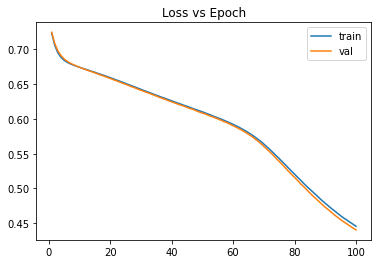

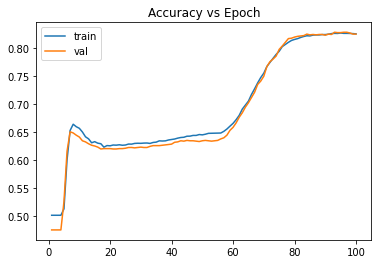

In [11]:
train_losses, val_losses = train(100, model, trainloader, valloader, optimizer, criterion) # train the model

### Performance variation with hidden layer size

100%|██████████| 5/5 [17:06<00:00, 205.26s/it]

Best hidden size: 8


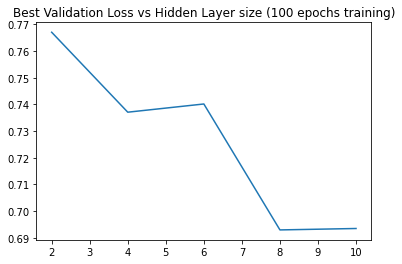

In [12]:
hidden_layer_sizes = [2, 4, 6, 8, 10]
best_val_losses = []

for size in tqdm(hidden_layer_sizes):
    model = XNOR_NN(hiddensize=size).to(device)
    _, val_losses = train(100, model, trainloader, valloader, optimizer, criterion, verbose=False)
    best_val_losses.append(np.min(val_losses))
    
plt.plot(hidden_layer_sizes, best_val_losses)
plt.title('Best Validation Loss vs Hidden Layer size (100 epochs training)')

print(f'Best hidden size: {hidden_layer_sizes[np.argmin(best_val_losses)]}')
plt.show()

### Performance variation with learning rate

Best lr: 0.1


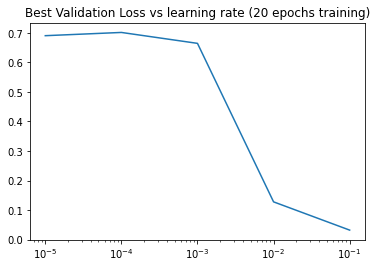

In [14]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
size = 8
best_val_losses = []

for lr in tqdm(lrs):
    model = XNOR_NN(hiddensize=size).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    _, val_losses = train(20, model, trainloader, valloader, optimizer, criterion, verbose=False)
    best_val_losses.append(np.min(val_losses))
    
plt.plot(lrs, best_val_losses)
plt.xscale('log')
plt.title('Best Validation Loss vs learning rate (20 epochs training)')

print(f'Best lr: {lrs[np.argmin(best_val_losses)]}')
plt.show()

### Training and evaluation of the best validation model

Epoch: 10: Train Loss: 0.049 | Val. Loss: 0.050
Epoch: 20: Train Loss: 0.033 | Val. Loss: 0.035
Epoch: 30: Train Loss: 0.027 | Val. Loss: 0.033
Epoch: 40: Train Loss: 0.023 | Val. Loss: 0.025
Epoch: 50: Train Loss: 0.021 | Val. Loss: 0.021
Epoch: 60: Train Loss: 0.019 | Val. Loss: 0.020
Epoch: 70: Train Loss: 0.018 | Val. Loss: 0.018
Epoch: 80: Train Loss: 0.017 | Val. Loss: 0.017
Epoch: 90: Train Loss: 0.015 | Val. Loss: 0.016
Epoch: 100: Train Loss: 0.015 | Val. Loss: 0.020


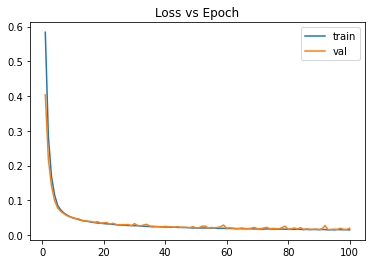

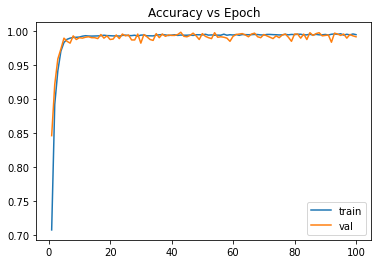

In [15]:
model = XNOR_NN(hiddensize=8).to(device)
criterion = torch.nn.CrossEntropyLoss() # CrossEntropyLoss is equivalent to LogSoftmax + NLLLoss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

train_losses, val_losses = train(100, model, trainloader, valloader, optimizer, criterion)

Loss on test data: 0.0171
Accuracy on test data: 99.60%


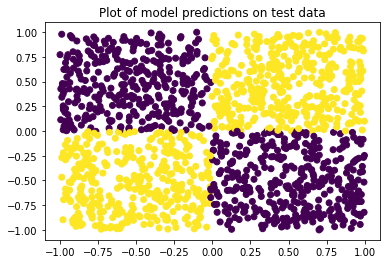

In [16]:
correct, total = 0, 0
yhats = []

loss, acc = evaluate_epoch(model, testloader, criterion)
for X, y in testloader:
    X, y = X.to(device), y.to(device)
    preds = model.predict(X)
    yhats.extend(preds.tolist())

print(f'Loss on test data: {loss:.4f}')
print(f'Accuracy on test data: {100*acc:.2f}%')
plt.scatter(dataset.X[testset.indices, 0], dataset.X[testset.indices, 1], c=yhats)
plt.title('Plot of model predictions on test data')
plt.show()

Thus we can clearly see from the plot of predictions that our model was able to successfully model the XNOR operation.